# BEE 4750 Homework 3: Dissolved Oxygen and Monte Carlo

**Name**: Tis, Matthew, Cella

**ID**: etb62, mth77, rms428

> **Due Date**
>
> Thursday, 10/03/23, 9:00pm

## Overview

### Instructions

-   Problem 1 asks you to implement a model for dissolved oxygen in a
    river with multiple waste releases and use this to develop a
    strategy to ensure regulatory compliance.
-   Problem 2 asks you to use Monte Carlo simulation to assess how well
    your strategy from Problem 1 performs under uncertainty.
-   Problem 3 (5750 only) asks you to identify where a third discharge
    should be placed to maintain regulatory compliance.

### Load Environment

The following code loads the environment and makes sure all needed
packages are installed. This should be at the start of most Julia
scripts.

In [22]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating project at `~/4750coding/Homeworks/hw3-hutchs-team-6`


In [23]:
using Random
using Plots
using LaTeXStrings
using Distributions
using CSV
using DataFrames

## Problems (Total: 50/60 Points)

### Problem 1 (30 points)

A river which flows at 6 km/d is receiving waste discharges from two
sources which are 15 km apart. The oxygen reaeration rate is 0.55
day<sup>-1</sup>, and the decay rates of CBOD and NBOD are are 0.35 and
0.25 day<sup>-1</sup>, respectively. The river’s saturated dissolved
oxygen concentration is 10m g/L.

If the characteristics of the river inflow and waste discharges are
given in <a href="#tbl-river" class="quarto-xref">Table 1</a>, write a
Julia model to compute the dissolved oxygen concentration from the first
wastewater discharge to an arbitrary distance `d` km downstream. Use
your model to compute the maximum dissolved oxygen concentration up to
50km downstream and how far downriver this maximum occurs.

| Parameter | River Inflow | Waste Stream 1 | Waste Stream 2 |
|:--:|---:|---:|---:|
| Inflow | 100,000 m<sup>3</sup>/d | 10,000 m<sup>3</sup>/d | 15,000 m<sup>3</sup>/d |
| DO Concentration | 7.5 mg/L | 5 mg/L | 5 mg/L |
| CBOD | 5 mg/L | 50 mg/L | 45 mg/L |
| NBOD | 5 mg/L | 35 mg/L | 35 mg/L |

Table 1: River inflow and waste stream characteristics for Problem 1.

**In this problem**:

-   Plot the dissolved oxygen concentration from the first waste stream
    to 50m downriver. What is the minimum value in mg/L?
-   What is the minimum level of treatment (% removal of organic waste)
    for waste stream 1 that will ensure that the dissolved oxygen
    concentration never drops below 4 mg/L, assuming that waste stream 2
    remains untreated? How about if only waste stream 2 is treated?
-   Suppose you are responsible for designing a waste treatment plan for
    discharges into the river, with a regulatory mandate to keep the
    dissolved oxygen concentration above 4 mg/L. Discuss whether you’d
    opt to treat waste stream 2 alone or both waste streams equally.
    What other information might you need to make a conclusion, if any?

To plot the dissolved oxygen concentration, we need to iterate through Streeter-Phelps equation [1]: 

$C(x) = C_s(1-\alpha_1) + C_0\alpha_1 - B_0\alpha_2 - N_0\alpha_3 + (\frac{P-R-S_B}{k_a})(1-\alpha_1 )$

$\alpha_1 = exp(\frac{-k_a x}{U})$\
$\alpha_2 = (\frac {k_c}{k_a - k_c})[exp(\frac{-k_c x}{U}) - exp(\frac{-k_a x}{U})]$\
$\alpha_2 = (\frac {k_n}{k_a - k_n})[exp(\frac{-k_n x}{U}) - exp(\frac{-k_a x}{U})]$



This will provide us with a concentration for every distance downstream. 

Givens:
- $k_a$ 
- $k_c$
- $k_n$
- $U$
- $C_s$

Assumptions:
1. The $P$ $R$ and $S_B$ terms have been omitted from this problem because their values are not provided
2. The system is in steady state

To successfully solve the problem, we will need to calculate $C_0$ $B_0$ and $N_0$ at two points: 

- 0km (at Waste Stream 1) 
- 15km (at Waste Stream 2) 

This will be done using the calculator below.

$\ CALCULATOR$

Givens and Assumptions:
- $Q$ should be changed from $m^3/d$ to $L/d$. This is done by multiplying each Q value by 1000. That means we have 10^8, 10^7 and 1.5*10^7 $L/d$ for the River, stream 1, and stream 2 respectively.

Explanation:
To find $C_0$, $B_0$ and $N_0$, use the Cmix equation from class [2]:
$\ Cmix = \frac{Q_1C_1 + Q_2C_2}{Q_1 + Q_2}$. 

Also, use the modified Cmix equation for multiple streams (1 and 1b)[2b]:
$\ Cmix = \frac{(Q_1+Q_{1b})C_1 + Q_2C_2}{Q_1+Q_{1b} + Q_2}$. 

The code below does this:
 1. Take in the values of all 'Givens'
 2. Calculate $C_{mix}$, $B_{mix}$ and $N_{mix}$ at 0km using equation [2].
 3. Use $C_{mix}$, $B_{mix}$, $N_{mix}$, the 'Givens' and equation [1] to solve $C_{15}$, $B_{15}$ and $N_{15}$. This is done by setting x=15 in equation [1].
 4. Finally, use these values to calculate $C_{mix}$, $B_{mix}$ and $N_{mix}$ at 15km


In [61]:
#solve the concentration at x location
function do_simulate(x, C0, B0, N0, ka, kn, kc, Cs, U)
    B = B0 * exp(-kc * x / U)
    N = N0 * exp(-kn * x / U)
    α1 = exp(-ka * x / U)
    α2 = (kc/(ka-kc)) * (exp.(-kc * x / U) - exp(-ka * x / U))
    α3 = (kn/(ka-kn)) * (exp(-kn * x / U) - exp(-ka * x / U))
    C = Cs * (1 - α1) + (C0 * α1) - (B0 * α2) - (N0 * α3)
    return (C, B, N)
end  

# set river properties
Qr = 10^8;
Qs1 = 10^7;
Qs2 = 1.5*10^7;
#set the given concentrations, THIS IS WHAT WE WILL CHANGE
Cr = 7.5;
Cs1 = 5;
Cs2 = 5;

Br = 5;
Bs1 = 50;
Bs2 = 45;

Nr = 5;
Ns1 = 35;
Ns2 = 35;

#rates 
ka = 0.55;
kc = 0.35;
kn = 0.25;

#solve the mix concentrations for location x=0;
 C0 = (Qr*Cr + Qs1*Cs1)/(Qr+Qs1);
 B0 = (Qr*Br + Qs1*Bs1)/(Qr+Qs1);
 N0 = (Qr*Nr + Qs1*Ns1)/(Qr+Qs1);

#Cs is 
Cs = 10
U = 6

#FIND Cs at 15
x = 15

# evaluate model over all x's
# this uses broadcasting
# and save the values as the river concentration at 15
 (C15,B15,N15) = (y -> do_simulate(y, C0, B0, N0, ka, kc, kn, Cs, U)).(x)

#now calculate the mix concentrations at 15 for post 15 data
 C15mix = ((Qr+Qs1)*C15 + Qs2*Cs2)/(Qr+Qs1+Qs2);
 B15mix = ((Qr+Qs1)*B15 + Qs2*Bs2)/(Qr+Qs1+Qs2);
 N15mix = ((Qr+Qs1)*N15 + Qs2*Ns2)/(Qr+Qs1+Qs2);






Now that we have the inital values for the critical points, we just need to run the streeter phelps equation and plot the results.

FUNCTION PLOTTER

The code below runs a function that:
1. Takes in all givens as well as the  $C_0$, $B_0$ and $N_0$ values calculated above.
2. Determines if x is before or after the second stream by checking x location relative to 15km.
3. If before the second stream, the function uses unmodified streeter phelps equation (Equation [1]) to solve $C$ $B$ and $N$ concentration.
4. If after the second stream, it uses a modified version of equation [1], where all 'x' is replaced with 'x-15' to account for a shifted 'start' position.

These calculated values are saved in a vector that can then be plotted, providing the concentration C of DO by position. We also included the lines for N and B, as done in class.

CALCULATE THE MINIMUM

This code also calculated the minimum DO value in mg/L. It does so simply by using the biult in 'minimum(x)' function, which can find the minimum value in our array of concentrations. It is found by the code to be 3.28 mg/L




minimum(C) = 3.706680738326016


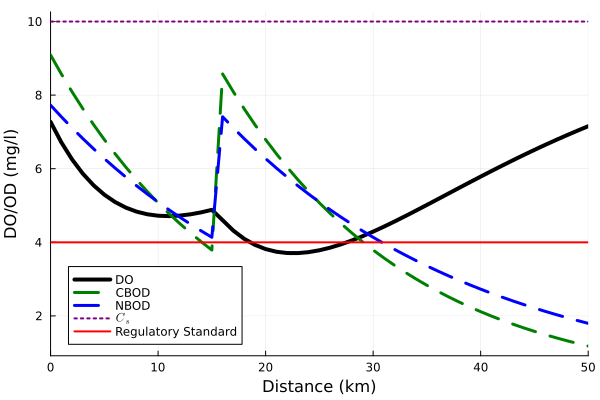

In [62]:
function do_simulate(x, C0, B0, N0,C15mix, B15mix, N15mix, ka, kn, kc, Cs, U)
    # set river properties
    ka = 0.55
    kc = 0.35
    kn = 0.25
 
    Cs = 10
    U = 6
    #change the 'initial' properties based on position
        if x<=15
            #solved on paper
            Cfore = C0
            Bfore = B0
            Nfore = N0
            B = B0 * exp(-kc * x / U)
            N = N0 * exp(-kn * x / U)
            α1 = exp(-ka * x / U)
            α2 = (kc/(ka-kc)) * (exp.(-kc * x / U) - exp(-ka * x / U))
            α3 = (kn/(ka-kn)) * (exp(-kn * x / U) - exp(-ka * x / U))
            C = Cs * (1 - α1) + (Cfore * α1) - (Bfore * α2) - (Nfore * α3)
        else #after the second input
            #solved on paper 
            Cafter = C15mix
            Bafter = B15mix
            Nafter = N15mix

            B = B0 * exp(-kc * (x-15) / U)
            N = N0 * exp(-kn * (x-15) / U)
            #we can get rid of B and N later, we really only need C
            α1 = exp(-ka * (x-15) / U)
            α2 = (kc/(ka-kc)) * (exp.(-kc * (x-15) / U) - exp(-ka * (x-15) / U))
            α3 = (kn/(ka-kn)) * (exp(-kn * (x-15) / U) - exp(-ka * (x-15) / U))
            C = Cs * (1 - α1) + (Cafter * α1) - (Bafter * α2) - (Nafter * α3)
        end

    
    return (C, B, N)
end  

#Now we can run through all x
x = 0:50

# evaluate model over all x's
# this uses broadcasting
do_out = (y -> do_simulate(y, C0, B0, N0, C15mix, B15mix, N15mix, ka, kc, kn, Cs, U)).(x)
# unpack outputs into individual arrays for C, B, and N
# this uses comprehensions to pull out the relevant components 
#of the tuples that our function outputs
C = [d[1] for d in do_out]
B = [d[2] for d in do_out]
N = [d[3] for d in do_out]

#find the minimum DO by using the min function on C after building the array
@show minimum(C)

# plot outputs
p1 = plot(; ylabel="DO/OD (mg/l)", xlabel="Distance (km)")
plot!(p1, x, C, color=:black, linewidth=4, label="DO")
plot!(p1, x, B, color=:green, label="CBOD", linestyle=:dash, linewidth=3)
plot!(p1, x, N, color=:blue, label="NBOD", linestyle=:dash, linewidth=3)
# plot Cs, which is a constant value 
plot!(p1, x, Cs * ones(length(x)), color=:purple, label=L"C_s", linestyle=:dot, linewidth=2)

#change regulatory standard to 4
hline!([4], color=:red, linewidth=2, label="Regulatory Standard")
xaxis!((0, 50))



$\ OPTIMIZE-stream1$

We will optimize by changing the initial conditions of B and N in our calculator code, and rerunning the function plotter code until our minimum is greater than 4. This guess and check method can be done more accurately by running a while loop and calling all functions until the minimum value of DO is above 4mg/L.

In the code below, we start by multiplying the given B and N values by a decimal value between 0 and 1. We then use these new B and N values in the same code blocks above, which calculate all C B and N values, and then plot the concentration and minimum value. 

If the minimum value is still below 4, we apply a higher percentage to both contaminants B and N and rerun the code blocks.

In [91]:
p=.182
treatedBs1 = (1-p)*50
treatedNs1 = (1-p)*35

28.630000000000003

In [92]:
#solve the concentration at x location
function do_simulate(x, C0, B0, N0, ka, kn, kc, Cs, U)
    B = B0 * exp(-kc * x / U)
    N = N0 * exp(-kn * x / U)
    α1 = exp(-ka * x / U)
    α2 = (kc/(ka-kc)) * (exp.(-kc * x / U) - exp(-ka * x / U))
    α3 = (kn/(ka-kn)) * (exp(-kn * x / U) - exp(-ka * x / U))
    C = Cs * (1 - α1) + (C0 * α1) - (B0 * α2) - (N0 * α3)
    return (C, B, N)
end  

# set river properties
Qr = 10^8;
Qs1 = 10^7;
Qs2 = 1.5*10^7;
#set the given concentrations, THIS IS WHAT WE WILL CHANGE
Cr = 7.5;
Cs1 = 5;
Cs2 = 5;

Br = 5;
Bs1 = treatedBs1;
Bs2 = 45;

Nr = 5;
Ns1 = treatedNs1;
Ns2 = 35;

#rates 
ka = 0.55;
kc = 0.35;
kn = 0.25;

#solve the mix concentrations for location x=0;
@show C0 = (Qr*Cr + Qs1*Cs1)/(Qr+Qs1);
@show B0 = (Qr*Br + Qs1*Bs1)/(Qr+Qs1);
@show N0 = (Qr*Nr + Qs1*Ns1)/(Qr+Qs1);

#Cs is 
Cs = 10
U = 6

#FIND Cs at 15
x = 15

# evaluate model over all x's
# this uses broadcasting
# and save the values as the river concentration at 15
 (C15,B15,N15) = (y -> do_simulate(y, C0, B0, N0, ka, kc, kn, Cs, U)).(x)

#now calculate the mix concentrations at 15 for post 15 data
@show C15mix = ((Qr+Qs1)*C15 + Qs2*Cs2)/(Qr+Qs1+Qs2);
@show B15mix = ((Qr+Qs1)*B15 + Qs2*Bs2)/(Qr+Qs1+Qs2);
@show N15mix = ((Qr+Qs1)*N15 + Qs2*Ns2)/(Qr+Qs1+Qs2);




C0 = (Qr * Cr + Qs1 * Cs1) / (Qr + Qs1) = 7.2727272727272725
B0 = (Qr * Br + Qs1 * Bs1) / (Qr + Qs1) = 8.263636363636364
N0 = (Qr * Nr + Qs1 * Ns1) / (Qr + Qs1) = 7.148181818181818
C15mix = ((Qr + Qs1) * C15 + Qs2 * Cs2) / (Qr + Qs1 + Qs2) = 5.276117017333145
B15mix = ((Qr + Qs1) * B15 + Qs2 * Bs2) / (Qr + Qs1 + Qs2) = 9.292421108190098
N15mix = ((Qr + Qs1) * N15 + Qs2 * Ns2) / (Qr + Qs1 + Qs2) = 6.82222884858569


minimum(C) = 4.0011447624426895


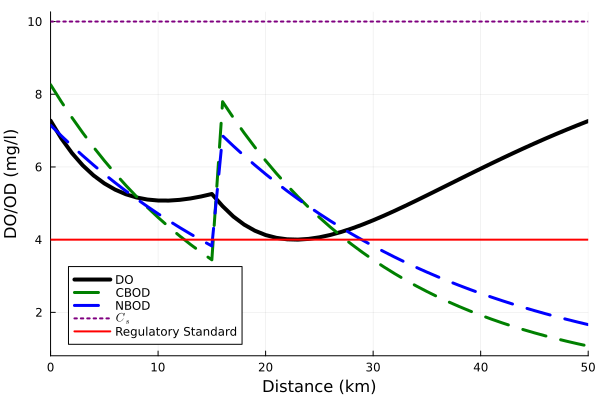

In [93]:
function do_simulate(x, C0, B0, N0,C15mix, B15mix, N15mix, ka, kn, kc, Cs, U)
    # set river properties
    ka = 0.55
    kc = 0.35
    kn = 0.25
 
    Cs = 10
    U = 6
    #change the 'initial' properties based on position
        if x<=15
            #solved on paper
            Cfore = C0
            Bfore = B0
            Nfore = N0
            B = B0 * exp(-kc * x / U)
            N = N0 * exp(-kn * x / U)
            α1 = exp(-ka * x / U)
            α2 = (kc/(ka-kc)) * (exp.(-kc * x / U) - exp(-ka * x / U))
            α3 = (kn/(ka-kn)) * (exp(-kn * x / U) - exp(-ka * x / U))
            C = Cs * (1 - α1) + (Cfore * α1) - (Bfore * α2) - (Nfore * α3)
        else #after the second input
            #solved on paper 
            Cafter = C15mix
            Bafter = B15mix
            Nafter = N15mix

            B = B0 * exp(-kc * (x-15) / U)
            N = N0 * exp(-kn * (x-15) / U)
            #we can get rid of B and N later, we really only need C
            α1 = exp(-ka * (x-15) / U)
            α2 = (kc/(ka-kc)) * (exp.(-kc * (x-15) / U) - exp(-ka * (x-15) / U))
            α3 = (kn/(ka-kn)) * (exp(-kn * (x-15) / U) - exp(-ka * (x-15) / U))
            C = Cs * (1 - α1) + (Cafter * α1) - (Bafter * α2) - (Nafter * α3)
        end

    
    return (C, B, N)
end  

#Now we can run through all x
x = 0:50

# evaluate model over all x's
# this uses broadcasting
do_out = (y -> do_simulate(y, C0, B0, N0, C15mix, B15mix, N15mix, ka, kc, kn, Cs, U)).(x)
# unpack outputs into individual arrays for C, B, and N
# this uses comprehensions to pull out the relevant components 
#of the tuples that our function outputs
C = [d[1] for d in do_out]
B = [d[2] for d in do_out]
N = [d[3] for d in do_out]

#find the minimum DO by using the min function on C after building the array
@show minimum(C)

# plot outputs
p1 = plot(; ylabel="DO/OD (mg/l)", xlabel="Distance (km)")
plot!(p1, x, C, color=:black, linewidth=4, label="DO")
plot!(p1, x, B, color=:green, label="CBOD", linestyle=:dash, linewidth=3)
plot!(p1, x, N, color=:blue, label="NBOD", linestyle=:dash, linewidth=3)
# plot Cs, which is a constant value 
plot!(p1, x, Cs * ones(length(x)), color=:purple, label=L"C_s", linestyle=:dot, linewidth=2)

#change regulatory standard to 4
hline!([4], color=:red, linewidth=2, label="Regulatory Standard")
xaxis!((0, 50))



When the organic matter (B and N) from stream 1 is decreased by 18.2%, the minimum DO is 4.0011. Thus, 18.2% is the required treatment if only stream 1 is treated.

In [ ]:
p=.1
treatedBs2 = (1-p)*45
treatedNs2 = (1-p)*35

In [ ]:
#solve the concentration at x location
function do_simulate(x, C0, B0, N0, ka, kn, kc, Cs, U)
    B = B0 * exp(-kc * x / U)
    N = N0 * exp(-kn * x / U)
    α1 = exp(-ka * x / U)
    α2 = (kc/(ka-kc)) * (exp.(-kc * x / U) - exp(-ka * x / U))
    α3 = (kn/(ka-kn)) * (exp(-kn * x / U) - exp(-ka * x / U))
    C = Cs * (1 - α1) + (C0 * α1) - (B0 * α2) - (N0 * α3)
    return (C, B, N)
end  

# set river properties
Qr = 10^8;
Qs1 = 10^7;
Qs2 = 1.5*10^7;
#set the given concentrations, THIS IS WHAT WE WILL CHANGE
Cr = 7.5;
Cs1 = 5;
Cs2 = 5;

Br = 5;
Bs1 = 50;
Bs2 = treatedBs2;

Nr = 5;
Ns1 = 35;
Ns2 = treatedNs2;

#rates 
ka = 0.55;
kc = 0.35;
kn = 0.25;

#solve the mix concentrations for location x=0;
 C0 = (Qr*Cr + Qs1*Cs1)/(Qr+Qs1);
 B0 = (Qr*Br + Qs1*Bs1)/(Qr+Qs1);
 N0 = (Qr*Nr + Qs1*Ns1)/(Qr+Qs1);

#Cs is 
Cs = 10
U = 6

#FIND Cs at 15
x = 15

# evaluate model over all x's
# this uses broadcasting
# and save the values as the river concentration at 15
 (C15,B15,N15) = (y -> do_simulate(y, C0, B0, N0, ka, kc, kn, Cs, U)).(x)

#now calculate the mix concentrations at 15 for post 15 data
 C15mix = ((Qr+Qs1)*C15 + Qs2*Cs2)/(Qr+Qs1+Qs2);
 B15mix = ((Qr+Qs1)*B15 + Qs2*Bs2)/(Qr+Qs1+Qs2);
 N15mix = ((Qr+Qs1)*N15 + Qs2*Ns2)/(Qr+Qs1+Qs2);




$\ OPTIMIZE-stream2$

Repeat the above optimization, but only changing stream 2


If we only treat stream 2, we can do a 21% total treatment and stay above 4mg/l.

I would likely only treat stream 2, because it requires far less treatment to keep the DO above 4mg/l. The main piece of information still needed is the cost. If it costs the same amount to treat either stream, then exclusive stream 2 treatment is a good choice. If stream 2 is more expensive to treat, we would need to do more research to choose the most effective strategy

### Problem 2 (20 points)

The simplest climate model involves capturing changes to the Earth’s
energy budget (it is commonly called the *energy balance model*, or
EBM). These changes are also called *radiative forcings* (RF), and can
result from several causes, including greenhouse gas emissions, volcanic
eruptions, and changes to the solar cycle. The EBM treats the Earth as a
0-dimensional sphere covered with water, which absorbs heat in response
to radiative forcings. Chanwith global temperature changes resulting
from imbalances in the average (over the entire surface area) heat flux.

The EBM equations are:

$$
\begin{align*}
\overbrace{\frac{dH}{dt}}^{\text{change in heat}} &= \overbrace{F}^{\substack{\text{radiative} \\ \text{forcing}}} - \overbrace{\lambda T}^{\substack{\text{change in} \\ \text{temperature}}} \\
\underbrace{C}_{\substack{\text{ocean heat} \\ \text{capacity}}} \frac{dT}{dt} &= F - \lambda T \\
c\underbrace{d}_{\substack{\text{ocean} \\ \text{mixing depth}}} \frac{dT}{dt} &= F - \lambda T,
\end{align*}
$$

where $c = 4.184\times 10^6 \mathrm{J/K/m}^2$ is the specific heat of
water per area, $d$ is the depth of the ocean mixed layer (we’ll assume
$d = 86 \mathrm{m}$), and $\lambda$ is the **climate feedback factor**
and controls how much the Earth warms in response to increased radiative
forcing (assume
$\lambda = 2.1^\circ \mathrm{C}/(\mathrm{W}/\mathrm{m}^2$)). The total
radiative forcing $F = F_\text{non-aerosol} + \alpha F_\text{aerosol}$,
where $\alpha$ is an uncertain scaling factor reflecting aerosol-cloud
feedbacks (we’ll assume $\alpha = 0.8$).

The code below loads historical and projected radiative forcings (under
the SSP5-8.5 future emissions scenario, which is the most extreme of the
scenarios used to project climate change impacts) from
`data/ERF_ssp585_1750-2500.csv` into a `DataFrame` object and calculates
the non-aerosol and aerosol components of those forcings.

> **Tip**
>
> Look closely at and experiment with the code below: `DataFrames` are a
> common Julia datatype for tabular data, and you may work more with
> them later in the semester or beyond! They are broadly similar to
> `DataFrames` from `pandas` in Python.

In [32]:
# Dataset from https://zenodo.org/record/3973015
# The CSV is read into a DataFrame object, and we specify that it is comma delimited
forcings_all = CSV.read("data/ERF_ssp585_1750-2500.csv", DataFrame, delim=",")

# Separate out the individual components
# Get total aerosol forcings
forcing_aerosol_rad = forcings_all[!,"aerosol-radiation_interactions"]
forcing_aerosol_cloud = forcings_all[!,"aerosol-cloud_interactions"]
forcing_aerosol = forcing_aerosol_rad + forcing_aerosol_cloud
# Calculate non-aerosol forcings from the total.
forcing_total = forcings_all[!,"total"]
forcing_non_aerosol = forcing_total - forcing_aerosol

751-element Vector{Float64}:
  0.25918289716993287
  0.24176756635599128
  0.21325975144045076
  0.17850291224529793
  0.1457411149414377
  0.09840432796857469
 -0.13383410588305977
  0.01724897551757567
  0.14777213389926366
  0.22712653379357609
  ⋮
 12.638871538651715
 12.636828023749903
 12.634811388909599
 12.632786007467395
 12.630739504290775
 12.628694395288093
 12.626673788131408
 12.624680005793559
 12.623637075242984

We can plot the aerosol and non-aerosol forcings below.

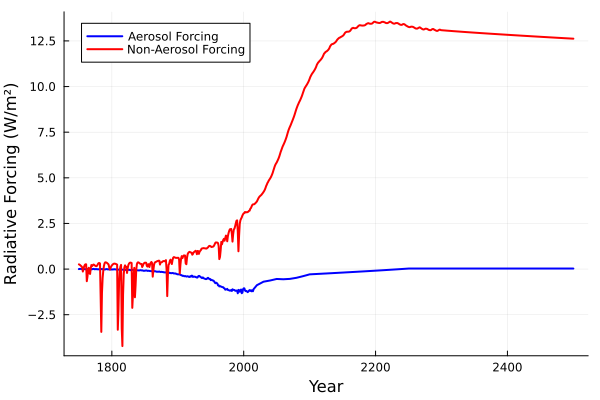

In [33]:
t = Int64.(forcings_all[!,"year"]) # Ensure that years are interpreted as integers
p_forcing = plot(; xlabel="Year", ylabel="Radiative Forcing (W/m²)")
plot!(p_forcing, t, forcing_aerosol, label="Aerosol Forcing", color=:blue, linewidth=2)
plot!(p_forcing, t, forcing_non_aerosol, label="Non-Aerosol Forcing", color=:red, linewidth=2)

**In this problem**:

-   Discretize the EBM to produce a simulation model of global mean
    temperatures $T$ over time as a result of total radiative forcings
    $F$.

-   Simulate global mean temperature anomalies (in $^\circ C$ relative
    to 1750) from your model using the historical and SSP5-8.5 radiative
    forcing data. Use an annual time step for the simulation (in
    seconds: $\Delta t = 31,558,152 \mathrm{s}$). You can assume
    $T(0) = 0^\circ C$. Plot the resulting temperature simulation.

-   The climate feedback factor $\lambda$ is one of the key
    uncertainties in projecting future temperatures, even assuming a
    particular scenario of future radiative forcing. Suppose we use the
    following distribution for $\lambda$,
    $$\lambda \sim \text{LogNormal}(\log(2.1), \log(2)/4).$$

    Use Monte Carlo simulation to estimate the expected temperature in
    2100 assuming SSP5-RCP 8.5 radiative forcings (with 95% confidence
    intervals). How does this estimate compare to the value you got from
    your simulation using the expected value of
    $\lambda=2.1^\circ \mathrm{C}/(\mathrm{W}/\mathrm{m}^2)$? How did
    you decide your sample set was sufficient?

**Problem 2 Answer**

First we discritize the EBM to find global mean temperatures over time as a result of total radiative dorcings F. 

We define $T_t$ based on $T_{t-1}$:\
$T_t = T_{t-1} + \Delta t \frac{\left( F_t - \lambda T_{t-1} \right)}{C}$

where \
$T_0 = 0$\
$\Delta t = 31,558,152 \mathrm{ s}$\
and\
$F_t = F_{\mathrm{non aersol}} + \alpha * F_{\mathrm{aersol}}$ \
where $\alpha = 0.8$\
$\lambda=2.1^\circ \mathrm{C}/(\mathrm{W}/\mathrm{m}^2)$\
and\
$C = c * d$\
where
$c = 4.16 * 10^6 (\mathrm{J}/\mathrm{K})/\mathrm{m}^2$ and
$d = 86 \mathrm{m}$

We use this discretization for n years, where n = 751 as provided by the forcings_all csv, to solve for the global mean temperatures. We take the index of the global mean temperature array at 351, as 2100 is 350 years after 1750. We find the expected final temperature in 2100 to be 4.67 °C

Expected final temperature in 2100: 4.673307603780873 °C


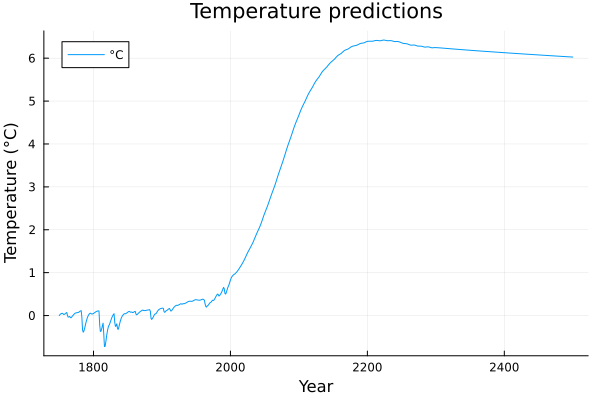

In [34]:
# variables
c = 4.184e6  # J/K/m^2
d = 86       # m
C = c * d    # ocean heat capacity
lambda = 2.1  # °C/(W/m²)
alpha = 0.8  # uncertain scaling factor
dt = 31558152  # year in seconds

# forcing total is forcing non aersol and alpha times forcing aersol 
forcing_total = forcing_non_aerosol + alpha * forcing_aerosol

years = forcings_all[!, "year"]
n_years = length(years) # 751 years
T = zeros(n_years) # T[0] = 0

for t = 2:n_years # have to start at 2 to access vector at [1]
    F_t = forcing_total[t] # t element of forcing_total vector
    # find T[t]
    T[t] = T[t-1] + (dt) * (F_t - lambda * T[t-1])/C 
end
T_final = T[351]  # final temp in 2100
println("Expected final temperature in 2100: $T_final °C")
plot(years, T, label = "°C", xlabel="Year", ylabel="Temperature (°C)", title = "Temperature predictions")

We now implement a Monte Carlo (MC) simulation to estimate the temperature in 2100 with a 95% confidence interval. \
We randomly sample $\lambda$ from the following distribution:\
 $\lambda \sim \text{LogNormal}(\log(2.1), \log(2)/4).$\
 and use the following formula to calculate the confidence interval:\
 $\tilde{\mu}_n \pm 1.96 \frac{\sigma_Y}{\sqrt{n}}$\
 In the code, we use this formula by multiplying 1.96 with the standard deviation frequency to show the ribbon of confidence for a given iteration.

 From the MC simulation, we find an average expected temperature in 2100 to be 4.70 °C. This is slightly higher than our estimate of 4.67 °C with a fixed $\lambda=2.1^\circ \mathrm{C}/(\mathrm{W}/\mathrm{m}^2)$.

 We conclude that 1000 simulations are enough for this Monte Carlo model because as our iterations approach 1000, the confidence interval stops decreasing, suggesting we are converging to the expected value as best we can. This is supported by the Law of Large Numbers, as our simulated temperature and expected temperature (the mean temperature we find from the MC simulation) are arbitrarily the same (the error is $\approx$ 1.8e-15) so the simulation is sufficiently well-behaved.

In [35]:
function temperature_mc(dt, C, n, forcing_total)
   """
   This function runs a Monte Carlo to simulate n iterations which calculate the mean global temperature 
   in 2100 based on data starting in 1750. 
   
   Inputs: n: number of Monte Carlo simulations
   Components of Temperature discitization
   dt (given = annual): time step
   C (given = c * d): ocean heat capacity
   forcing_total: equation for forcing_total function; alpha is randomly sampled from lambda_dist

   Returns: Temperature and standard deviation from 2100
   """
    T_sim = zeros(length(forcing_total))
    T_2100 = zeros(n)
    lambda_dist = LogNormal(log(2.1),(log(2)/4)) # log-normal distribution for lambda
    st_dev = zeros(length(forcing_total))
    st_dev[1] = 0
    st_dev_2100 = zeros(n)
    # Iterate through n simulations
    for j = 1:n
        lambda_sample = rand(lambda_dist)
        for i = 2:length(forcing_total)
            F_t = forcing_total[i-1]
            T_sim[i] = T_sim[i-1] + (dt)*(F_t-lambda_sample*T_sim[i-1])/C
            st_dev[i] = std(T_sim[1:i]) / sqrt(j) # Compare temp relative to 1750
        end
        T_2100[j] = T_sim[351] # 2100 - 1750 = 350... 351 would be index at year 350 because julia starts at index [1]
        st_dev_2100[j] = st_dev[351]
    end
    return(T_2100,st_dev_2100)
end

temperature_mc (generic function with 1 method)

In [36]:
n_simulations = 1000
# find temperature 1000 times 
T_2100, st_dev_2100 = temperature_mc(dt, C, n_simulations, forcing_total)

# Calculates running estimate of temperature in the year 2100 relative to the year 1750
T_run_est = cumsum(T_2100)./(1:n)
n_vec = collect(1:n)

ev_temp_2100 = mean(T_2100) # mean as expected value
st_error = st_dev_2100[n] / sqrt(n)
final_t = T_run_est[end]
error = abs(final_t -ev_temp_2100)

println("Expected final temperature in 2100: $ev_temp_2100 °C")
println("Estimated final temperature for 1000 interations: $final_t °C")
println("Final error between estimated and expected final temperatures for 1000 iterations (in °C): $error")
# Plots
plt = plot(
    n_vec, T_run_est, 
    ribbon=1.96 * st_dev_2100,
    xlabel="Iteration (n)",
    ylabel="Temperature Estimate (°C)",
    label= "Temperature",
    title = "Estimate vs. Iteration of Temp in 2100"
)
hline!(plt, [ev_temp_2100], color="red", linestyle=:dash, label = "Expected temperature") 


UndefVarError: UndefVarError: `n` not defined

### Problem 3 (10 points)

**This problem is only required for students in BEE 5750**.

A factory is planning a third wastewater discharge into the river
downstream of the second plant. This discharge would consist of 5
m<sup>3</sup>/day of wastewater with a dissolved oxygen content of 4.5
mg/L and CBOD and NBOD levels of 50 and 45 mg/L, respectively.

**In this problem**:

-   Assume that the treatment plan you identified in Problem 1 is still
    in place for the existing discharges. If the third discharge will
    not be treated, under the original inflow conditions (7.5 mg/L DO),
    how far downstream from the second discharge does this third
    discharge need to be placed to keep the river concentration from
    dropping below 4 mg/L?

## References

List any external references consulted, including classmates.

Camila Monter showed us how her group was able to keep track of the estimates for making the confidence intervals using the following code:

T_run_est = cumsum(T_2100)./(1:n)

n_vec = collect(1:n)

This code keeps track of the running estimate of temperatures in the year 2100 relative to the year 1750.

Also, the MC function and plotting methods were taken from the class example about dice.
